<a href="https://colab.research.google.com/github/mmcenta/le-net-beginner/blob/master/notebooks/torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

# Modern LeNet in PyTorch

Let's load the MNIST dataset from `torchvision`. We will also apply a
transformation pipeline that converts the images to tensors and normalizes them
to the [-1.0, 1.0] range.

First, we import the necessary modules and classes.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

Then we load the train and dev sets into `DataLoaders`.

In [0]:
# Declare image transform pipeline
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))                               
])

# Load train set
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

# Load dev set
dev_set = MNIST(root='./data', train=False, download=True, transform=transform)
dev_loader = DataLoader(dev_set, batch_size=64, shuffle=False, num_workers=2)

Let's see a random batch of images and their labels.

3 2 9 5 6 4 3 7
4 8 2 1 5 3 5 7
8 6 2 3 4 3 1 9
5 6 5 4 2 8 4 0
9 1 1 2 7 7 0 8
8 8 9 3 9 8 2 0
9 6 9 9 7 2 1 9
6 3 0 9 7 2 1 6


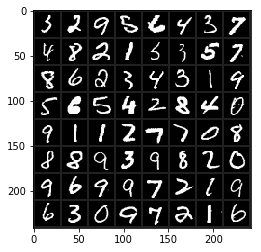

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Show an image
def imshow(img):
    img = 0.3081 * img + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\n'.join(' '.join('%s' % labels[j].item() for j in range(8*i, 8*(i+1))) for i in range(8)))

## Define the model

Next we need to define the model we'll be using. We will be using a convolutional neural network deeply inspired on the classic LeNet architecture. 

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ModernLeNet(nn.Module):
  def __init__(self):
    super(ModernLeNet, self).__init__()
    
    # Convolutional layers
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.maxpool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.maxpool2 = nn.MaxPool2d(2)

    # Fully connected layers
    self.fc1 = nn.Linear(16 * 6 * 6, 120) # unroll 6x6 image with 16 filters
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    print(x.size())

    # Convolutional part
    x = F.relu(self.conv1(x))
    print(x.size())
    x = self.maxpool1(x)
    print(x.size())
    x = F.relu(self.conv2(x))
    print(x.size())
    x = self.maxpool2(x)
    print(x.size())


    # Flatten the output volume
    n_batch = x.size()[0]
    x = x.view(n_batch, -1)
    print(x.size())

    # Fully connected part
    x = F.relu(self.fc1(x))
    print(x.size())
    x = F.relu(self.fc2(x))
    print(x.size())
    x = self.fc3(x)
    print(x.size())

    return x

model = ModernLeNet()

Before defining the loss function and the optimizer, transfer the model to the GPU if avaible.

In [13]:
# Get the device that will be used in training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transfer the model to the correct device
model.to(device)

print(device)

cuda:0


We will use the cross entropy loss for this clasification task, as well as the Adam optimizer with default parameters.

In [0]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Train the model

We will iterate over the training data for 100 epochs and print the loss each 5 epochs.

In [15]:
num_training_examples = len(train_set)
epochs = []
losses = []

# Train for 100 epochs
for epoch in range(100):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    # Get the inputs and transfer them to device
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Train on this mini-batch
    outputs = model(inputs)           # forward pass
    loss = criterion(outputs, labels) # calculate loss
    loss.backward()                   # backward pass
    optimizer.step()                  # update parameters

    # Update loss
    running_loss += loss.item()
      
  # Each 5 epochs, print the loss
  if epoch % 5 == 4:
    print('[epoch %d] loss: %.3f' % (epoch + 1, running_loss / num_training_examples))

  # Store the loss for this epoch
  epochs.append(epoch)
  losses.append(running_loss)

print('Finished Training')

torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 26, 26])
torch.Size([64, 6, 13, 13])
torch.Size([64, 16, 11, 11])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])


RuntimeError: ignored